In [5]:
import seaborn as sns
from sklearn.mixture import BayesianGaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans

import pandas as pd
import numpy as np

from pathlib import Path
import csv

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from imageio import imread


In [12]:
def get_marginal_mean(arr,dim="x", meanNN_TF=False):
    '''
    E(x) = int x f(x) dx
    
    arr      : np.array containing 2-d heatmap, shape is (height, width) 
    dim      : if "x", the marginal mean of X (width) is calcualted
                if "y", the marginal mean of Y (height)is calcualted 
    meanNN_TF: if False, the marginal mean is calculated using all the pixels.
                if True, then the marginal mean is calculated using the neighboor of the high marginal density region.
                The "neighboor" is calculated in two steps:
                (1) order the intensity of the marginal density 
                in the decreasing manner, 
                (2) include the top densities until the corresponding pixel coordinate hits the pixel border.
                
    '''
    if dim == "x":
        axis = 0
    elif dim == "y":
        axis = 1
    mardens = arr.sum(axis=axis)
    asort   = np.argsort(mardens)[::-1]
    
    if meanNN_TF:
        Npixel = np.min(np.where((asort == 0) | (asort == (len(asort)-1) ))) + 1
    else: 
        Npixel = -1 
    mardens = mardens[asort][:Npixel]
    mardens = mardens / np.sum(mardens) ## rescale so that marginal density adds up to 1
    
    xcoor   = asort[:Npixel]
    
    meanx   = np.sum((xcoor*mardens)[:Npixel])
    return(meanx)
    
def get_marginal_sd(arr,dim="x",verbose=False,meanNN_TF=False):
    '''
        E( (x - barx)**2 ) = int (x-barx)**2 f(x) dx
        
    arr     : np.array containing 2-d heatmap, shape is (height, width) 
    dim     : if "x", the marginal mean of X (width) is calcualted
                if "y", the marginal mean of Y (height)is calcualted 
    meanNN_TF: if False, the marginal mean is calculated using all the pixels.
                if True, then the marginal mean is calculated using the neighboor of the high marginal density region.
                The "neighboor" is calculated in two steps:
                (1) order the intensity of the marginal density 
                in the decreasing manner, 
                (2) include the top densities until the corresponding pixel coordinate hits the pixel border.
    '''
    if dim == "x":
        axis = 0
    elif dim == "y":
        axis = 1
    mardens = arr.sum(axis=axis)
    xcoor   = np.arange(len(mardens))
    
    meanx   = get_merginal_mean(arr, dim=dim, meanNN_TF=meanNN_TF)
    varx    = np.sqrt(np.sum((xcoor - meanx)**2*mardens))
    if verbose:
        print("{} total dens = {:4.3f}, mean = {:5.2f}".format(
                dim,
                np.sum(mardens),
                meanx)
                )
    return(varx)
def get_cov(arr,verbose=True,meanNN_TF=False):
    '''
        E( (x - barx)*(y - bary) ) = int (x-barx)*(y - bary) f(x,y) dxdy
        
    arr     : np.array containing 2-d heatmap, shape is (height, width) 
    meanNN_TF: if False, the marginal mean is calculated using all the pixels.
                if True, then the marginal mean is calculated using the neighboor of the high marginal density region.
                The "neighboor" is calculated in two steps:
                (1) order the intensity of the marginal density 
                in the decreasing manner, 
                (2) include the top densities until the corresponding pixel coordinate hits the pixel border.
                
                recommended to set True to improve the variance estimate performance when not all the density is included in the heatmap image.
                
    '''

    ## prepare the storage space
    x_coor_mat = np.zeros_like(arr)
    for icol in range(x_coor_mat.shape[1]):
        x_coor_mat[:, icol] = icol
        
    y_coor_mat = np.zeros_like(arr)
    for irow in range(y_coor_mat.shape[0]):
        y_coor_mat[irow, :] = irow
        
    meanx   = get_merginal_mean(arr, dim = "x", meanNN_TF=meanNN_TF) ## scalar
    meany   = get_merginal_mean(arr, dim = "y", meanNN_TF=meanNN_TF) ## scalar 

    cov     = np.sum((x_coor_mat - meanx)*(y_coor_mat - meany )*arr)

    return(cov)

In [3]:
def read_grayscale_pngs(path, width=20, height=13):
    path = Path(path)
    if not path.exists():
        print("Path doesn't exist")
        return None

    # print(len([name for name in os.listdir('{}/.'.format(path)) if os.path.isfile(name)]))
    num_files = len(list(path.glob('**/*.png'))) # Calculate amount of files in directory
    # num_files = len([f for f in path.iterdir() if path.joinpath(f).is_file()]) # Calculate amount of files in directory

    ids = np.empty(num_files)
    images = np.empty((num_files, 13, 20))

    for i, image_path in enumerate(path.glob('**/*.png')):
        images[i] = np.array(imread(image_path))[:, :, 0] # Pixel data: It's grayscale so take only Red values from [R, G, B, A]
    return images

In [6]:
legal = read_grayscale_pngs("../data_processing/out/legal/orig")
illegal = read_grayscale_pngs("../data_processing/out/illegal/orig")  


<AxesSubplot:>

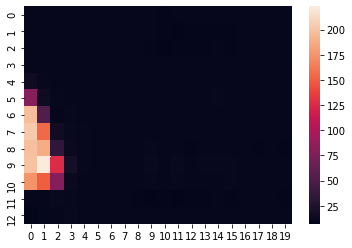

In [8]:
image = illegal[200]
sns.heatmap(image)

In [9]:
get_merginal_mean(image)

5.193985982364911

In [13]:
get_merginal_sd(image)

419.06105492955624

In [15]:
get_cov(image)

-20324.50991194396

In [28]:
legal_features = pd.DataFrame({
    "min": np.min(legal, axis=(1,2)),
    "max": np.max(legal, axis=(1,2)),
    "mean": np.mean(legal, axis=(1,2)),
    "var": np.var(legal, axis=(1,2)),
    "sum": np.sum(legal, axis=(1,2)),
    "ptp": np.ptp(legal, axis=(1,2)),
    "std": np.std(legal, axis=(1,2)),
    "trace": np.trace(legal, axis1=1, axis2=2),

    "mmeanx": np.array([get_merginal_mean(image, dim='x', meanNN_TF=False) for image in legal]),
    "mmeanxTF": np.array([get_merginal_mean(image, dim='x', meanNN_TF=True) for image in legal]),

    "msdx": np.array([get_merginal_sd(image, dim='x', meanNN_TF=False) for image in legal]),
    "msdxTF": np.array([get_merginal_sd(image, dim='x', meanNN_TF=True) for image in legal]),

    "mmeany": np.array([get_merginal_mean(image, dim='y', meanNN_TF=False) for image in legal]),
    "mmeanyTF": np.array([get_merginal_mean(image, dim='y', meanNN_TF=True) for image in legal]),

    "msdy": np.array([get_merginal_sd(image, dim='y', meanNN_TF=False) for image in legal]),
    "msdyTF": np.array([get_merginal_sd(image, dim='y', meanNN_TF=True) for image in legal]),

    "cov": np.array([get_cov(image, meanNN_TF=False) for image in legal]),
    "covTF": np.array([get_cov(image, meanNN_TF=True) for image in legal]),

    "target": 0
})

illegal_features = pd.DataFrame({
    "min": np.min(illegal, axis=(1,2)),
    "max": np.max(illegal, axis=(1,2)),
    "mean": np.mean(illegal, axis=(1,2)),
    "var": np.var(illegal, axis=(1,2)),
    "sum": np.sum(illegal, axis=(1,2)),
    "ptp": np.ptp(illegal, axis=(1,2)),
    "std": np.std(illegal, axis=(1,2)),
    "trace": np.trace(illegal, axis1=1, axis2=2),

    "mmeanx": np.array([get_merginal_mean(image, dim='x', meanNN_TF=False) for image in illegal]),
    "mmeanxTF": np.array([get_merginal_mean(image, dim='x', meanNN_TF=True) for image in illegal]),

    "msdx": np.array([get_merginal_sd(image, dim='x', meanNN_TF=False) for image in illegal]),
    "msdxTF": np.array([get_merginal_sd(image, dim='x', meanNN_TF=True) for image in illegal]),

    "mmeany": np.array([get_merginal_mean(image, dim='y', meanNN_TF=False) for image in illegal]),
    "mmeanyTF": np.array([get_merginal_mean(image, dim='y', meanNN_TF=True) for image in illegal]),

    "msdy": np.array([get_merginal_sd(image, dim='y', meanNN_TF=False) for image in illegal]),
    "msdyTF": np.array([get_merginal_sd(image, dim='y', meanNN_TF=True) for image in illegal]),

    "cov": np.array([get_cov(image, meanNN_TF=False) for image in illegal]),
    "covTF": np.array([get_cov(image, meanNN_TF=True) for image in illegal]),

    "target": 1
})

features = pd.concat((illegal_features, legal_features))

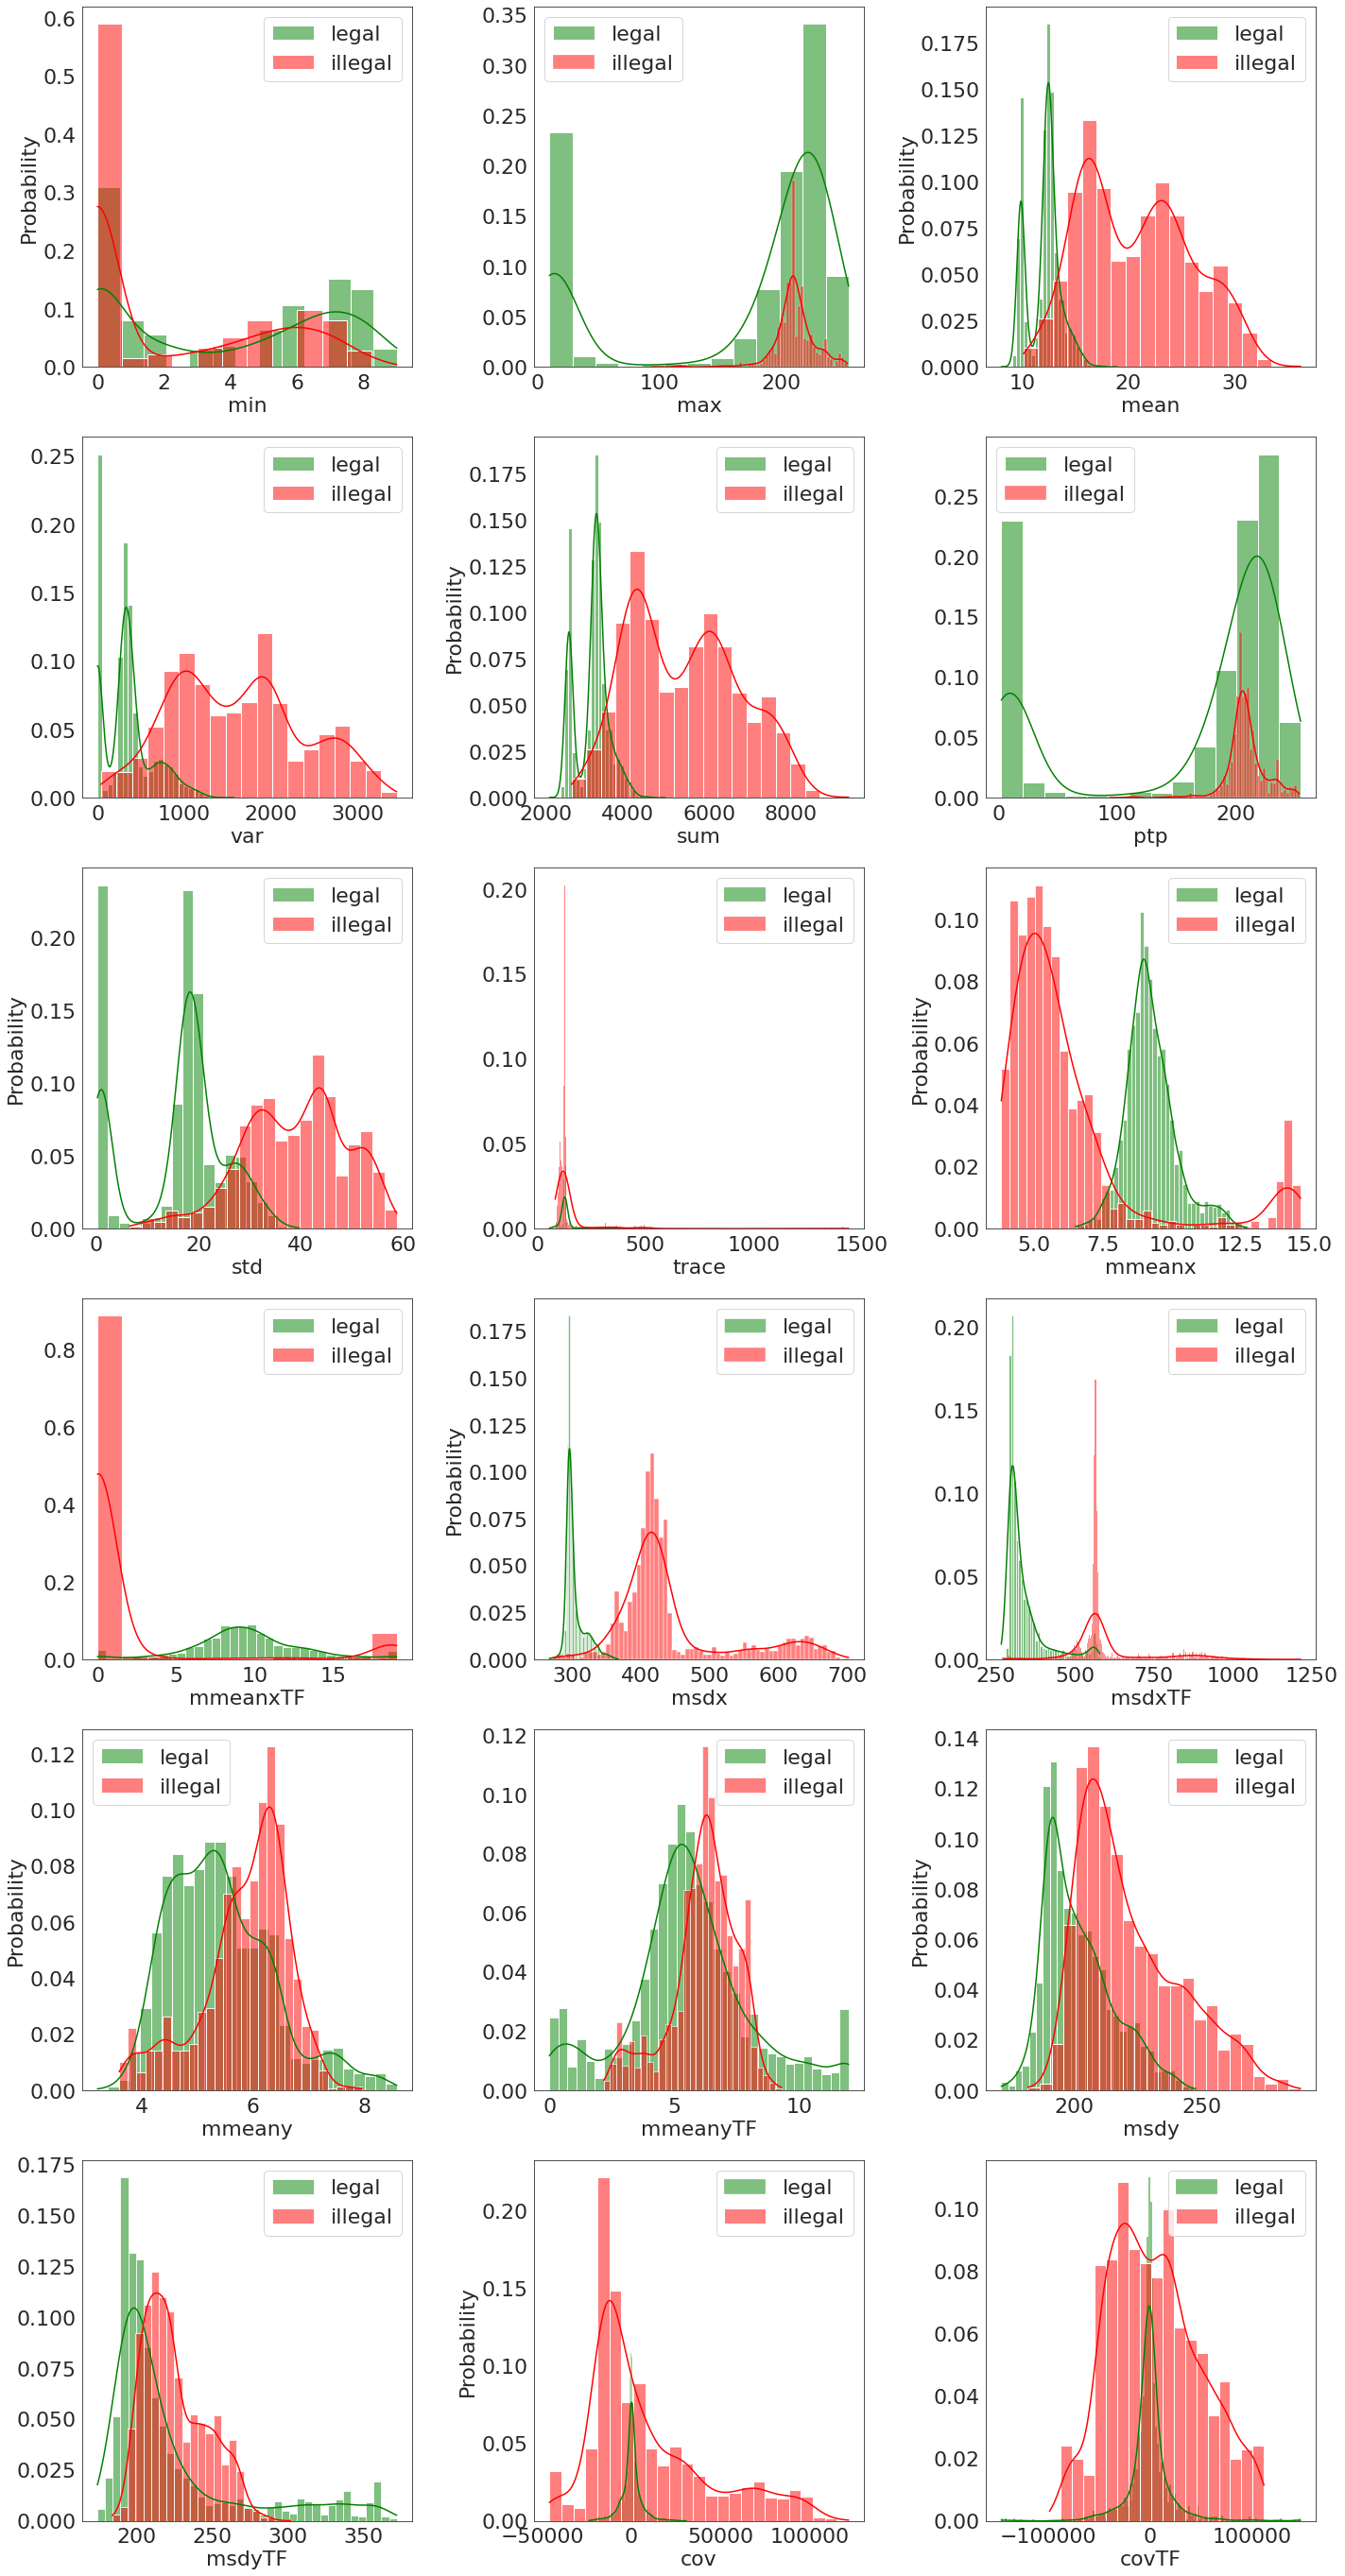

In [41]:
fig = plt.figure(figsize=(20, 40))
plt.rcParams.update({'font.size': 22})
i = 1
for feature in features.columns[: features.columns.slice_locs(end='covTF')[1]]: # Cycle through columns until and including "trace"
    plt.subplot(6, 3, i)
    sns.histplot(data=legal_features, x=feature, kde=True, stat="probability", color='g', label='legal')
    sns.histplot(data=illegal_features, x=feature, kde=True, stat="probability", color='r', label='illegal')
    if i % 3 == 0:
        plt.ylabel(None)
    plt.legend(loc='best')
    i += 1
# fig.suptitle('Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig('figures/ai_ml_feature_distribution.pdf')

<Figure size 2160x2880 with 0 Axes>

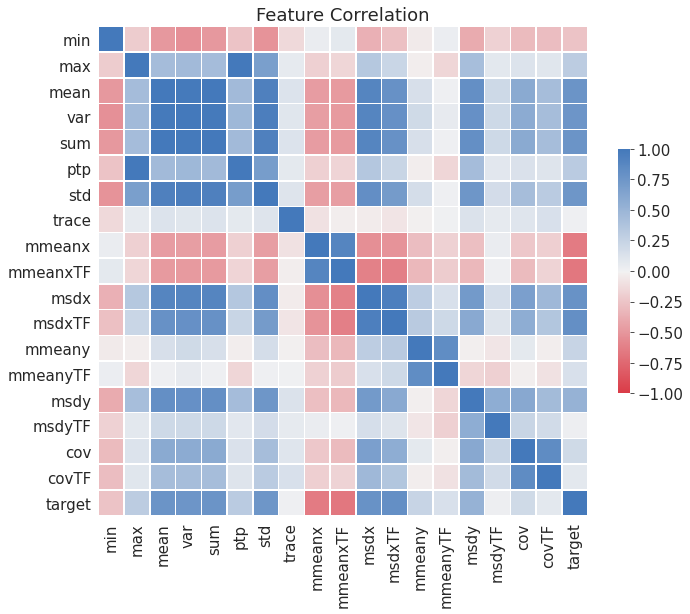

In [61]:
plt.figure(figsize=(30,40))
corr = features.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.set_style(style = 'white')
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap,
        square=True, vmin=-1.0, vmax=1.0,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.title('Feature Correlation')
plt.savefig('data_elimination_feature_corr.pdf')

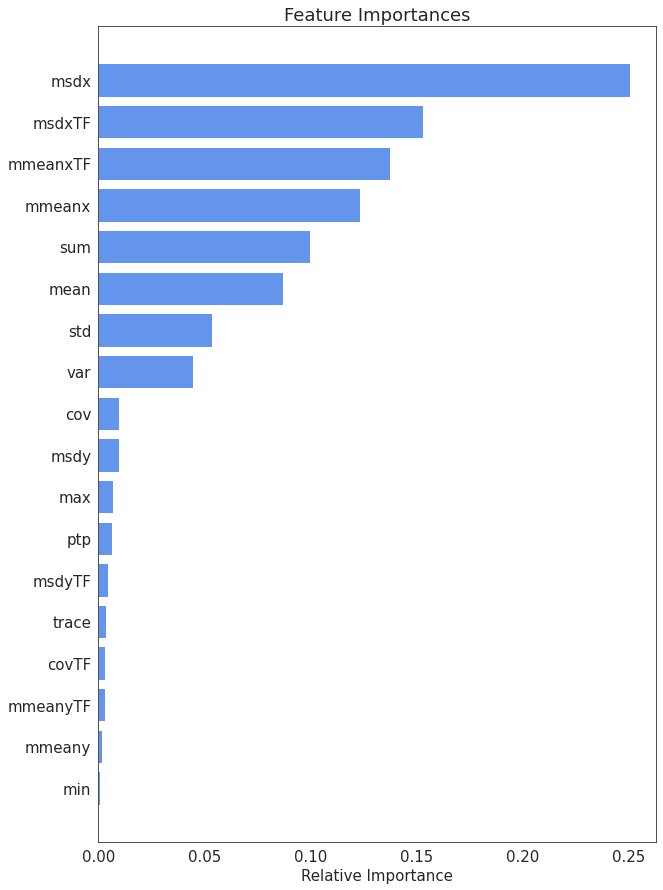

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split# Spliiting data into test and train sets

X_train, X_test, y_train, y_test = train_test_split(features.drop('target', axis=1), features['target'], test_size=0.20, random_state=0)# fitting the model
model = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)# plotting feature importances
features_forest = features.drop('target', axis=1).columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,15))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='cornflowerblue', align='center')
plt.yticks(range(len(indices)), [features_forest[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show(),